# INTRODUCTION
## Language Classification
Language is a vital part of human connection, Language allows us to share our ideas, thoughts, and feelings with others. It has the power to build societies, but also tear them down. South Africa is a multicultural society that is characterized by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic, and political life of South African society.
The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages.

## Problem Statement
This project takes text in any of South Africa's 11 Official languages and determines which language the text is written in.
The aim of this project is to take text which is in any of South Africa's 11 Official languages and identify correctly which language the text is in. This is a classical Natural Language Processing (NLP) endeavour.

# Table of contents:
[Initial View of the Train and Test Dataset](#section-one)

[Preprocessing](#section_two)

[Exploratory Data Analysis](#section_three)

[Feacture Extraction](#section-four)

[Model Building & Evaluation](#section-five)

[Using GridSearchCV for Hyper Parameter Tuning](#section-six)

[Conclusion](#section-seven)

[Reference](#section-eight)

In [3]:
#Import libraries
# Standard libraries
import re
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt 
# Style
import matplotlib.style as style 
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
style.use('seaborn-poster')
from PIL import Image
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix

<a id="section-one"></a>
## Initial View of the the Train and Test Dataset

In [4]:
df_train= pd.read_csv('train_set.csv')   #Train Dataset
df_test= pd.read_csv('test_set.csv')    #Test Dataset

### Taking a general look of the train datasets

In [5]:
df_train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [8]:
df_train.info() #Observe the column data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


In [224]:

df_train['lang_id'].value_counts()

xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: lang_id, dtype: int64

### Observation:
The Training Dataset is balanced, with all the targets having the same nume number of observations

<a id='section_two'></a>
## Preprocessing

In [9]:
# Check for null values
df_train.isna().sum()

lang_id    0
text       0
dtype: int64

In [38]:
def extract_text(text):
    t1 = re.sub(r'@\S+',' ',text)    # Removing any @symbol
    t1 = re.sub(r'http\S+',' ',t1)   # Removing any URLs
    t1 = re.sub(r'\d+', '', t1)      # Remove numbers
    t1 = re.sub(r"[,.;':@#?!\&/$]+\ *", ' ', t1) #Remove punctuations
    
    return t1.strip().lower()       # Removing extra spaces and sending only lowercase alphanumeric characters

In [11]:
### Creat dataframe copies to preserve the original
df1 = df_train.copy()
df2 = df_test.copy()
df_train.shape

(33000, 2)

In [39]:
#Clean the text using the extract_text function 
df1['text'] = df1['text'].apply(extract_text)   
df2['text'] = df2['text'].apply(extract_text)

In [13]:
print(df1.shape)
df1.head()

(33000, 2)


,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


<a id='section_three'></a>
## Exploratory Data Analysis

In [14]:
list(df1['lang_id'].unique())   # "Make a list of all the labels"

['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso', 'sot', 'afr']

C:\Users\qsabd\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


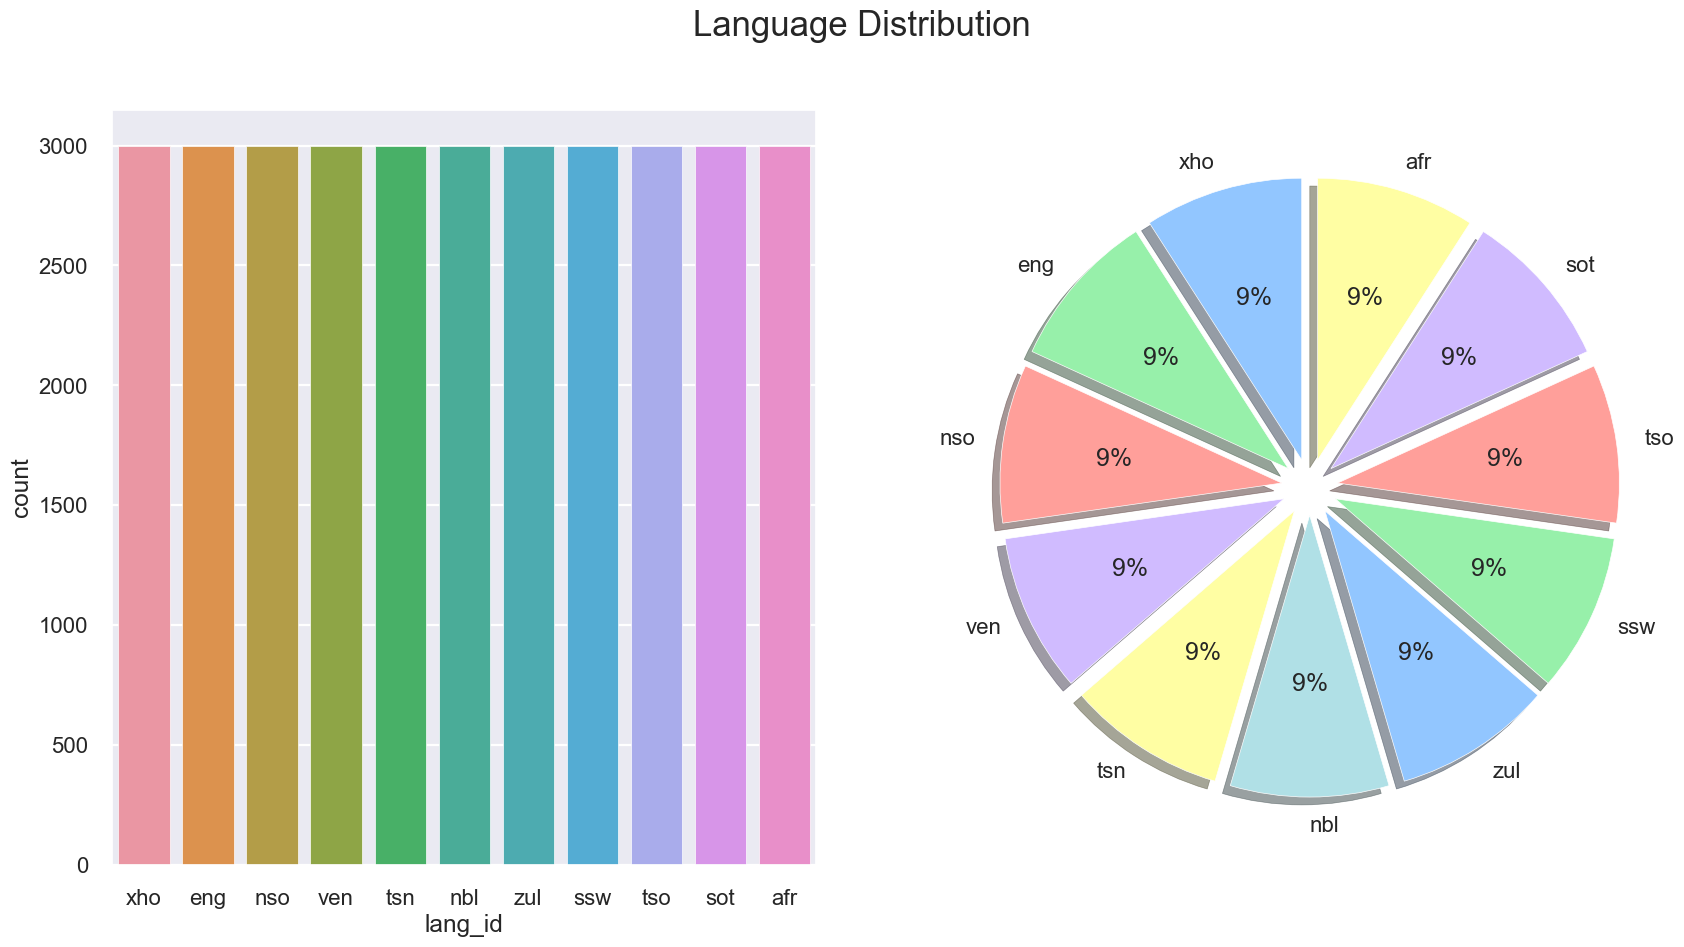

In [19]:
# Display language distribution distribution
style.use('seaborn-pastel')

fig, axes = plt.subplots(ncols=2, 
                         nrows=1, 
                         figsize=(20, 10), 
                         dpi=100)

sns.countplot(df1['lang_id'], ax=axes[0])

labels=list(df1['lang_id'].unique()) 

axes[1].pie(df1['lang_id'].value_counts(),
            labels=labels,
            autopct='%1.0f%%',
            shadow=True,
            startangle=90,
            explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1))

fig.suptitle('Language Distribution', fontsize=25)
plt.show()

### Observation
The dataset is balanced as observed, therefore there would be no need to resample the dataset.

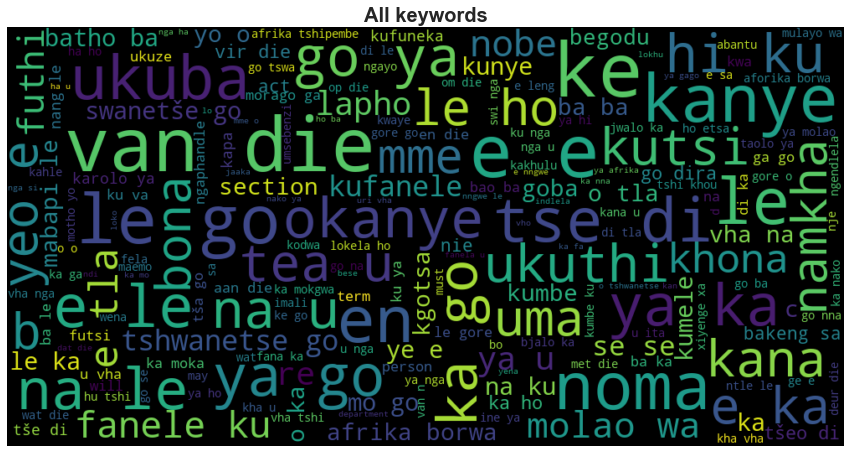

In [16]:
# visualize the frequent words
all_words = " ".join([sentence for sentence in df1['text']])

wordcloud = WordCloud(width=1000, height=500, random_state=42, max_font_size=90).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("All keywords", size=20, weight="bold")
plt.show()

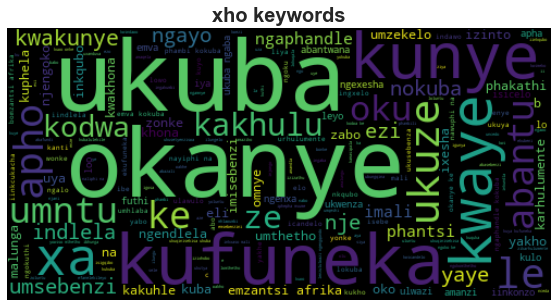

In [17]:
# visualize the frequent words for language 
all_words = " ".join([sentence for sentence in df1['text'][df1['lang_id']== 'xho']])

wordcloud = WordCloud(width=500, height=250, random_state=42, max_font_size=90).generate(all_words)

# plot the graph
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("xho keywords", size=20, weight="bold")
plt.show()

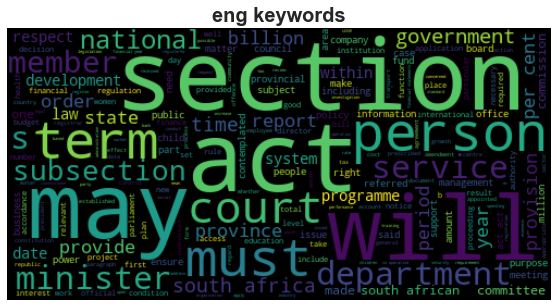

In [20]:
# visualize the frequent words for language 'eng'
all_words = " ".join([sentence for sentence in df1['text'][df1['lang_id']== 'eng']])

wordcloud = WordCloud(width=500, height=250, random_state=42, max_font_size=90).generate(all_words)

# plot the graph
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("eng keywords", size=20, weight="bold")
plt.show()

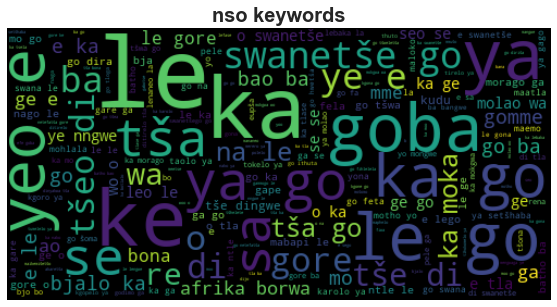

In [21]:
# visualize the frequent words for language 'nso'
all_words = " ".join([sentence for sentence in df1['text'][df1['lang_id']== 'nso']])

wordcloud = WordCloud(width=500, height=250, random_state=42, max_font_size=90).generate(all_words)

# plot the graph
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("nso keywords", size=20, weight="bold")
plt.show()

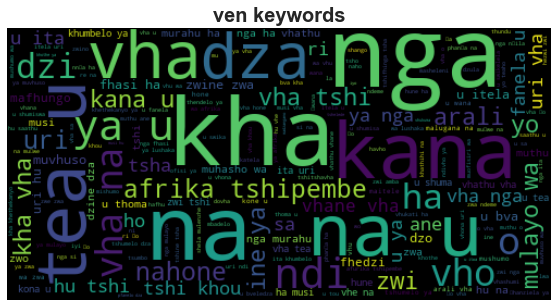

In [22]:
# visualize the frequent words for language 'ven'
all_words = " ".join([sentence for sentence in df1['text'][df1['lang_id']== 'ven']])

wordcloud = WordCloud(width=500, height=250, random_state=42, max_font_size=90).generate(all_words)

# plot the graph
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("ven keywords", size=20, weight="bold")
plt.show()

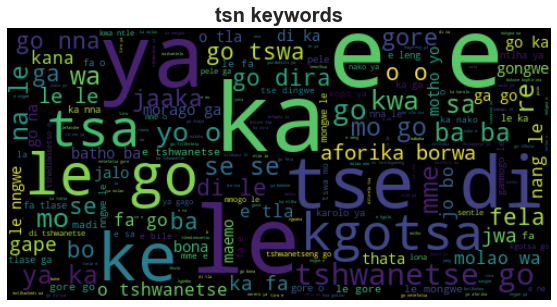

In [23]:
# visualize the frequent words for language 'tsn'
all_words = " ".join([sentence for sentence in df1['text'][df1['lang_id']== 'tsn']])

wordcloud = WordCloud(width=500, height=250, random_state=42, max_font_size=90).generate(all_words)

# plot the graph
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("tsn keywords", size=20, weight="bold")
plt.show()

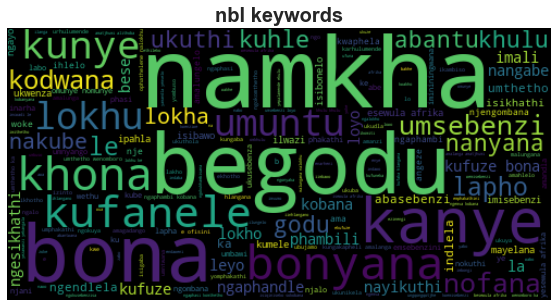

In [24]:
# visualize the frequent words for language 'nbl'
all_words = " ".join([sentence for sentence in df1['text'][df1['lang_id']== 'nbl']])

wordcloud = WordCloud(width=500, height=250, random_state=42, max_font_size=90).generate(all_words)

# plot the graph
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("nbl keywords", size=20, weight="bold")
plt.show()

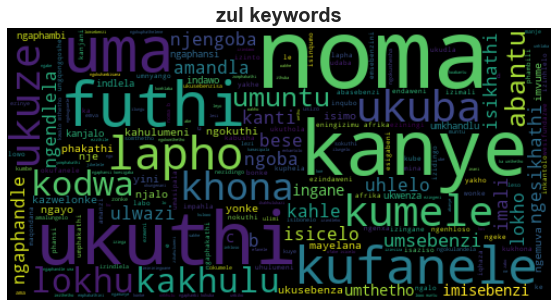

In [25]:
# visualize the frequent words for language 'zul'
all_words = " ".join([sentence for sentence in df1['text'][df1['lang_id']== 'zul']])

wordcloud = WordCloud(width=500, height=250, random_state=42, max_font_size=90).generate(all_words)

# plot the graph
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("zul keywords", size=20, weight="bold")
plt.show()

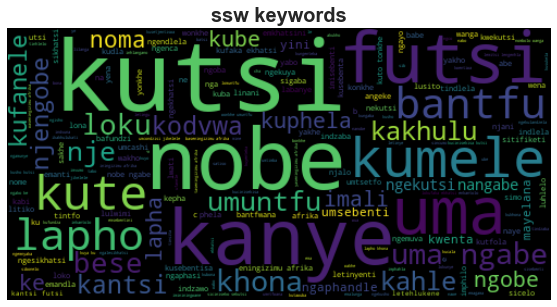

In [26]:
# visualize the frequent words for language 'ssw'
all_words = " ".join([sentence for sentence in df1['text'][df1['lang_id']== 'ssw']])

wordcloud = WordCloud(width=500, height=250, random_state=42, max_font_size=90).generate(all_words)

# plot the graph
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("ssw keywords", size=20, weight="bold")
plt.show()

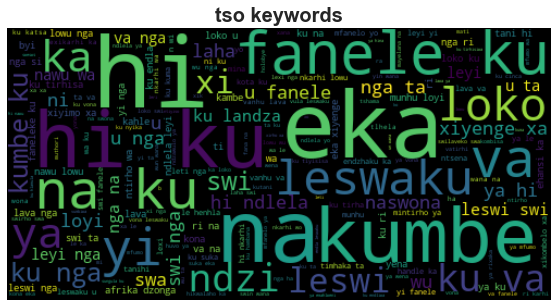

In [37]:
# visualize the frequent words for language 'tso'
all_words = " ".join([sentence for sentence in df1['text'][df1['lang_id']== 'tso']])

wordcloud = WordCloud(width=500, height=250, random_state=42, max_font_size=90).generate(all_words)

# plot the graph
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("tso keywords", size=20, weight="bold")
plt.show()

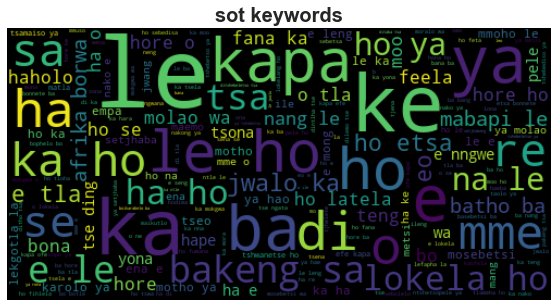

In [27]:
# visualize the frequent words for language 'sot'
all_words = " ".join([sentence for sentence in df1['text'][df1['lang_id']== 'sot']])

wordcloud = WordCloud(width=500, height=250, random_state=42, max_font_size=90).generate(all_words)

# plot the graph
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("sot keywords", size=20, weight="bold")
plt.show()

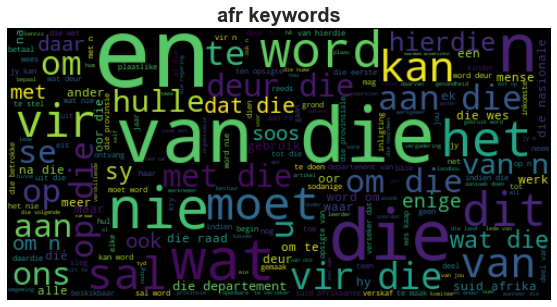

In [28]:
# visualize the frequent words for language 'afr'
all_words = " ".join([sentence for sentence in df1['text'][df1['lang_id']== 'afr']])

wordcloud = WordCloud(width=500, height=250, random_state=42, max_font_size=90).generate(all_words)

# plot the graph
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("afr keywords", size=20, weight="bold")
plt.show()

<a id="section-four"></a>

## Feacture Extraction

### Vectorization using the TfidfVectorizer,
The TFIDF vectorizer assigns word frequency scores that try to highlight words that are more frequent in a document but not across documents. The TfidfVectorizer will tokenize documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents. Another advantage of this method is that the resulting vectors are already scaled.

In [32]:
tfidf_vect = TfidfVectorizer()  #Calling the vectorizer
vect_train = tfidf_vect.fit_transform(df1['text']) #Fitting and the Vectorizer to the training data and transorming the training data
vect_test = tfidf_vect.transform(df2['text'])       #Transforming the test data

In [33]:
# Split the dataset into train & validation (80%  and 20% for validation) for model training
X_train, X_test, y_train, y_test = train_test_split(vect_train, df1['lang_id'], random_state=42, test_size=0.2)

<a id="section-five"></a>
## Model Building

####  Logistic Regression
Logistic regression is a statistical model that uses a logistic function for predicting binary classes. Here, a logistic function or logistic curve is a sigmoid curve and the logistic model has dependent and independent variables where the value of dependent variable is either 0 or 1. Thus, logistics regression is a common and useful regression method for predicting binary classes i.e. two classes

In [30]:
log_reg = LogisticRegression(multi_class='ovr')   # Calling the Logistic Regression Model

In [34]:
log_reg.fit(X_train, y_train) #Fitting the model

LogisticRegression(multi_class='ovr')

In [35]:
# Generate predictions
y_pred = log_reg.predict(X_test)

In [36]:
# Classification report
print(classification_report(y_test, y_pred))

import warnings
warnings.filterwarnings('ignore')

              precision    recall  f1-score   support

         afr       1.00      0.99      0.99       583
         eng       1.00      1.00      1.00       615
         nbl       0.98      0.99      0.98       583
         nso       1.00      0.99      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       0.98      1.00      0.99       584
         tsn       1.00      1.00      1.00       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       0.99      1.00      0.99       609
         zul       0.99      0.97      0.98       590

    accuracy                           0.99      6600
   macro avg       0.99      0.99      0.99      6600
weighted avg       0.99      0.99      0.99      6600



In [54]:
ypred_test = log_reg.predict(vect_test)    #Make prediction for the test dataset

In [56]:
# Generate CSV for submission on Kaggle
paf = pd.DataFrame(ypred_test, columns=['lang_id']) #Create a dataframe from the predicted values
output = pd.DataFrame({'index':df2['index']})       #Create a dataframe from the index column from test dataset
submission5 = output.join(paf)                      #Join the two dataframes
submission5.to_csv('KazeemHack.csv', index=False)   # Generate the csv file

#### Support Vector Machine  (SVM)
SVMs are interesting models. Like logistic regression, they fit a linear decision boundary. However, unlike logistic regression, SVMs do this in a non-proabilistic way and are able to fit to non-linear data using an algorithm known as the kernel trick. Furthermore, SVMs can be used for both classification and regression. In sklearn, these are called SVC (Support Vector Classifier) and SVR (Support Vector Regression) respectively.

In [58]:
svm_new = SVC(kernel = 'rbf',gamma = 1.5,  C = 0.5) #Calling the SVM
svm_new.fit(X_train, y_train)                       # Train the SVM

SVC(C=0.5, gamma=1.5)

In [59]:
y_svm = svm_new.predict(vect_test)   #Make prediction on the Test Dataset

In [61]:
y_tested = svm_new.predict(X_test)  #Make prediction on the validation set

In [62]:
# Classification report for the SVM
print(classification_report(y_test, y_tested))

import warnings
warnings.filterwarnings('ignore')

              precision    recall  f1-score   support

         afr       1.00      0.98      0.99       583
         eng       1.00      0.99      0.99       615
         nbl       0.99      0.97      0.98       583
         nso       1.00      0.99      1.00       625
         sot       1.00      0.99      1.00       618
         ssw       1.00      0.99      0.99       584
         tsn       1.00      1.00      1.00       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       0.98      0.99      0.98       609
         zul       0.93      0.99      0.96       590

    accuracy                           0.99      6600
   macro avg       0.99      0.99      0.99      6600
weighted avg       0.99      0.99      0.99      6600



In [63]:
# Generate CSV for submission on Kaggle
paf = pd.DataFrame(y_svm, columns=['lang_id'])
output = pd.DataFrame({'index':df2['index']})
submission5 = output.join(paf)
submission5.to_csv('Kazeem_svm.csv', index=False)

<a id="section-six"></a>
### Using GridSearchCV for Hyper Parameter Tuning

In [70]:
nfolds = 2

Cs = [0.5, 1]
gammas = [1.0, 1.5]

param_grid = {
    'C'     : Cs,
    'gamma' : gammas
    }

grid_SVM = GridSearchCV(SVC(), param_grid, scoring='f1', cv=nfolds)
grid_SVM.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.5, 1], 'gamma': [1.0, 1.5]}, scoring='f1')

In [71]:
y_svm_best = grid_SVM.predict(X_test)

In [72]:
# Classification report
print(classification_report(y_test, y_svm_best))  #Report for Tuned SVM

import warnings
warnings.filterwarnings('ignore')

              precision    recall  f1-score   support

         afr       1.00      0.99      0.99       583
         eng       1.00      0.99      1.00       615
         nbl       0.99      0.98      0.98       583
         nso       1.00      0.99      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       1.00      1.00      1.00       584
         tsn       1.00      1.00      1.00       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       0.97      1.00      0.98       609
         zul       0.97      0.99      0.98       590

    accuracy                           0.99      6600
   macro avg       0.99      0.99      0.99      6600
weighted avg       0.99      0.99      0.99      6600



In [73]:
grid_SVM.best_params_

{'C': 0.5, 'gamma': 1.0}

In [76]:
y_grid = grid_SVM.predict(vect_test)

In [77]:
paf = pd.DataFrame(y_grid, columns=['lang_id'])
output = pd.DataFrame({'index':df2['index']})
submission5 = output.join(paf)
submission5.to_csv('Kazeem_svm3.csv', index=False)

In [75]:
grid_SVM.best_params_

{'C': 0.5, 'gamma': 1.0}

In [134]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)

In [139]:
#Perform 10-fold cross-validation with logistic regression
logreg = LogisticRegression()
logreg, X, y, cv=10

In [140]:
print(cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean())

In [173]:
param_grid_lr = {
    'max_iter': [50, 100],                      
    'solver': ['lbfgs'],   
    'class_weight': ['balanced']                                    
}

In [174]:
#Perform Kfold Cross-Validation with Gridsearch on LogisticRegression to determine the optimum parameters
logModel_grid = GridSearchCV(estimator=LogisticRegression(random_state=42), param_grid=param_grid_lr, verbose=1, cv=20, n_jobs=-1)
logModel_grid.fit(vect_train, df1['lang_id'])
print(logModel_grid.best_estimator_)

Fitting 20 folds for each of 2 candidates, totalling 40 fits
LogisticRegression(class_weight='balanced', random_state=42)


In [153]:
logModel_grid.best_params_

{'class_weight': 'balanced', 'max_iter': 50, 'solver': 'lbfgs'}

In [168]:
y_grid = logModel_grid.predict(X_test)

In [175]:
logModel_grid.best_params_

{'class_weight': 'balanced', 'max_iter': 100, 'solver': 'lbfgs'}

<a id="section-seven"></a>
### Conclusion

South Africa, one of the countries with the most official languages, can benefit immensely from a language classification model built to deepen its democracy, citizen participation, and National Unity. 
Creating “language-aware data products” is becoming more critical for businesses and organizations. Leveraging machine learning and NLP, organizations can interact with their customers both rationally and emotionally, improve their customer experience, and provide customized assistance. This can be even more effective when the language of the prospective customer can be classified easily.

SVMs are interesting models. Like logistic regression, they fit a linear decision boundary. However, unlike logistic regression, SVMs do this in a non-proabilistic way and are able to fit to non-linear data using an algorithm known as the kernel trick. Furthermore, SVMs can be used for both classification and regression.

<a id="section-eight"></a>
### REFERENCE

Idil Ismiguzel (2022). Applying Text Classification Using Logistic Regression.[online] Medium. 
Available at:https://medium.com/analytics-vidhya/applying-text-classification-using-logistic-regression-a-comparison-between-bow-and-tf-idf-1f1ed1b83640

Ashin Shakya (2020):Text Classification Using Logistic Regression. [online] Medium.
Available at:https://medium.com/@ashins1997/text-classification-dfe370bf7044. [Accessed 12 December. 2022

Kashyap, A. (2017). Top 5 tricks to make plots look better. [online] Medium. Available at: https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08 [Accessed 17 Jun. 2020].